In [21]:
import re
import os
import numpy as np
import pandas as pd

import nltk
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import corpus_bleu
nltk.download('punkt')  # download pre-trained Punkt tokenizer for English

import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import torch.utils.data as Data
from torch.nn.utils.rnn import pack_padded_sequence

from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.metrics import accuracy_score, f1_score, recall_score
from sklearn import metrics
from sklearn.utils import shuffle

import matplotlib.pyplot as plt

import json

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Wording embedding

## Cleaning and Tokenization

In [23]:
# 1. Product name
# 2. Product name + price
# 3. Product name + price + image (multimodal)

In [24]:
def data_loading(file_name):
  data = pd.read_csv(file_name)
  data = shuffle(data)
  name = list(data['ProductName'].values)
  cat = list(data['level_1'].values)
  name_cat = pd.DataFrame(zip(name, cat), columns = ['Name', 'Category'])

  # ! use utils2.get_dict()
  # dictionary of category to id
  cat2id = {cat_name: id for id, cat_name in enumerate(sorted(set(cat)))}
  # dictionary of id to category
  id2cat = {id: cat_name for id, cat_name in enumerate(sorted(set(cat)))}

  # list of category(id) for each product
  product_catId = [cat2id.get(name) for _, name in enumerate(cat)]

  return name, cat, name_cat, cat2id, id2cat, product_catId

In [25]:
def tokenize(corpus):
    data = re.sub(r'[,!?;-]+', '.', corpus)
    data = nltk.word_tokenize(data)
    name_str = ''
    for ch in data:
      if ch.isalpha(): # number in name will not affect the classification
        name_str = name_str + ch.lower() + ' '           
    return name_str

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
file_name = '/content/drive/My Drive/Product_Classification/Data/data_unqiue_all_branches.csv'
name, cat, name_cat, cat2id, id2cat, product_catId = data_loading(file_name)

## Word2Vec

In [28]:
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
import multiprocessing
import torchtext.vocab as vocab

In [29]:
name_cat = name_cat.apply([tokenize])
name_cat.columns = ['Name', 'Category']

In [30]:
def load_embedding(filename):
  cache = '.vector_cache'
  if not os.path.exists(cache):
    os.mkdir(cache)
  
  # https://blog.csdn.net/weixin_38008864/article/details/99915084
  vector = vocab.Vectors(name = filename, cache = cache)
  return vector

In [31]:
import random

def encode_text_to_features(vector, text, my_dict, word_dim, max_length):

  # set the word length for each product name
  name_list = list(name_cat['Name'])
  
  vec = []
  for k in text.split():
    if k in list(my_dict.keys()) and len(vec) < max_length:
      vec.append(my_dict[k])

  if not vec:
    vec = [[0] * word_dim] * max_length

  vec.extend([[0] * word_dim] * (max_length - len(vec)))
  
  return vec

In [32]:
def wor2vec_method(option, name_cat, word_dim, max_length):

  # txt containing variable for classification: product name (tokenized) - product category (tokenized)
  name_cat_text = open(option + '_name_cat.txt', 'w', encoding = 'utf-8')
  for _, row in name_cat.iterrows():
  # ? Whether add category in word embedding
    name_cat_text.write(row['Name'] + ' ' + row['Category'] + '\n')
  name_cat_text.close()

  # Word2Vec Model
  readline = open(option + '_name_cat.txt', 'r', encoding = 'utf-8')
  model = Word2Vec(LineSentence(readline), size = word_dim, window = 5, workers = multiprocessing.cpu_count(), min_count = 10)
  model.wv.save_word2vec_format(option + '_word2vec.txt', binary = False)
  model.save(option + "_word2vec.model")


  # Word2Vec Dictionary: product name charactor (tokenized) - vector
  model = Word2Vec.load(option + "_word2vec.model")
  my_dict = dict({})
  for _, key in enumerate(model.wv.vocab):
      my_dict[key] = model.wv[key].tolist()

  # word embedding
  vector = load_embedding(option + '_word2vec.txt')


  # Vectors for all product names
  features = [encode_text_to_features(vector, text, my_dict, word_dim, max_length) for text in name_cat['Name']]

  return features
  # features and cat use for futher model training

# Model Architecture

In [33]:
class LSTM(nn.Module):
  def __init__(self, num_classes, input_size, hidden_size, num_layers):
    super(LSTM, self).__init__()
    
    # num_classes = output_size
    self.num_classes = num_classes 

    # The number of expected features in the input x
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    
    self.lstm = nn.LSTM(input_size = input_size, 
                        hidden_size = hidden_size, 
                        num_layers = num_layers, 
                        batch_first = True
                        )

    self.fc = nn.Linear(hidden_size, num_classes)

  def forward(self, x):
    # x.shape = (seq_len, batch, input_size)

    # Initilize h and c
    # Their size is (num_layers * num_directions, batch, hidden_size)

    # print(x.shape)
    h_shape = (self.num_layers, x.shape[0], self.hidden_size)
    h = Variable(torch.rand(h_shape))
    c = Variable(torch.rand(h_shape))
    # print(h.shape)

    # Inputs: input, (h_0, c_0)
    _, (h_out, _) = self.lstm(x, (h, c))

    # self.fc has size (batch_size, hidden_size)
    out = self.fc(h_out[0])

    return out


# Model Training

## Training for each epoch

In [34]:
def train(train_loader, device, model, loss_function, optimizer):

  """
  Performs one epoch's training.
  :param train_loader: DataLoader for training data
  :param model: model
  :param loss_function: loss layer
  :param optimizer: optimizer to update model's weights
  """

  model.train()

  loss_batch = []
  accu_batch = []

  for X, y in train_loader:

    X = X.to(device)
    y = y.type(torch.LongTensor).to(device)
    
    pred_y = model(X)
    loss = loss_function(pred_y, y)
    loss_batch.append(loss.item())

    softmax = nn.Softmax(dim = 1)
    pred_y = softmax(pred_y)

    _, pred_label = torch.max(pred_y, dim = 1)
    accu_batch.append(float(torch.sum(pred_label == y).item() / len(pred_label)))

    # update gradients in each training batch
    # so that the updating speed will be higher
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  return loss_batch, accu_batch

## Testing for each epoch

In [35]:
def test(train_loader, device, model, loss_function):

  """
  Performs one epoch's testing.
  :param train_loader: DataLoader for testing data
  :param model: model
  :param loss_function: loss layer
  """

  model.eval()

  loss_batch_test = []
  accu_batch_test = []

  for X_test, y_test in test_loader:
    
    X_test = X_test.to(device)
    y_test = y_test.type(torch.LongTensor).to(device)

    pred_y_test = model(X_test)
    loss = loss_function(pred_y_test, y_test)
    loss_batch_test.append(loss.item())

    softmax = nn.Softmax(dim = 1)
    pred_y_test = softmax(pred_y_test)

    _, pred_label_test = torch.max(pred_y_test, dim = 1)
    accu_batch_test.append(float(torch.sum(pred_label_test == y_test).item() / len(pred_label_test)))

  return loss_batch_test, accu_batch_test

## Embedding training

In [36]:
## original word2vec features and id
## ori_features and ori_cat for further model training

word_dim = 300
max_length = 10

features = wor2vec_method('ori', name_cat, word_dim, max_length)
categoryId = product_catId.copy()

## Model Training

In [37]:
# Change to variable tensor
features = Variable(torch.Tensor(features))
categoryId = Variable(torch.Tensor(categoryId))
print(features.shape)

torch.Size([13136, 10, 300])


In [38]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(features, categoryId, test_size=0.20, random_state=42)

# Training and testing dataset
train_dataset = Data.TensorDataset(X_train, y_train)
test_dataset = Data.TensorDataset(X_test, y_test)

# DataLoader
batch_size = 200
train_loader = Data.DataLoader(train_dataset, batch_size, True)
test_loader = Data.DataLoader(test_dataset, batch_size, True)

In [39]:
# Initialize the model
num_classes = len(cat2id)
input_size = word_dim
hidden_size = 100
num_layers = 1
learning_rate = 0.01

In [40]:
model = LSTM(num_classes, input_size, hidden_size, num_layers).to(device)
loss_function = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

loss_epoch_train = []
accu_epoch_train = []
loss_epoch_test = []
accu_epoch_test = []

epoches = 15

for epoch in range(epoches):

  # training

  loss_batch_train, accu_batch_train = train(train_loader, device, model, loss_function, optimizer)
  

  # testing

  loss_batch_test, accu_batch_test = test(train_loader, device, model, loss_function)


  if epoch % 1 == 0:
    print('Epoch:{} -- Training: Loss:{:.4f}, Accuracy:{:.4f} %; Testing: Loss:{:.4f}, Accuracy:{:.4f} %'.format(
        epoch + 1, 
        float(np.mean(loss_batch_train)), 100*float(np.mean(accu_batch_train)), 
        float(np.mean(loss_batch_test)), 100*float(np.mean(accu_batch_test)))
    )

  loss_epoch_train.append(float(np.mean(loss_batch_train)))
  accu_epoch_train.append(float(100*np.mean(accu_batch_train)))
  loss_epoch_test.append(float(np.mean(loss_batch_test)))
  accu_epoch_test.append(float(100*np.mean(accu_batch_test)))

Epoch:1 -- Training: Loss:1.2181, Accuracy:56.4892 %; Testing: Loss:0.7417, Accuracy:76.3878 %
Epoch:2 -- Training: Loss:0.6357, Accuracy:79.0321 %; Testing: Loss:0.5445, Accuracy:81.8827 %
Epoch:3 -- Training: Loss:0.5092, Accuracy:83.2621 %; Testing: Loss:0.5085, Accuracy:83.3061 %
Epoch:4 -- Training: Loss:0.4539, Accuracy:84.7813 %; Testing: Loss:0.4891, Accuracy:83.0051 %
Epoch:5 -- Training: Loss:0.4136, Accuracy:86.0894 %; Testing: Loss:0.4279, Accuracy:84.5459 %
Epoch:6 -- Training: Loss:0.3890, Accuracy:86.7701 %; Testing: Loss:0.4532, Accuracy:84.3112 %
Epoch:7 -- Training: Loss:0.3590, Accuracy:87.8917 %; Testing: Loss:0.3990, Accuracy:85.9082 %
Epoch:8 -- Training: Loss:0.3409, Accuracy:88.5234 %; Testing: Loss:0.3628, Accuracy:87.3061 %
Epoch:9 -- Training: Loss:0.3250, Accuracy:89.0112 %; Testing: Loss:0.3469, Accuracy:88.6633 %
Epoch:10 -- Training: Loss:0.3103, Accuracy:89.5342 %; Testing: Loss:0.3604, Accuracy:88.6122 %
Epoch:11 -- Training: Loss:0.2907, Accuracy:90.20

# Evaluation

In [41]:
def evaluation(predictions, labels, id2label, model_name=None):
    acc = accuracy_score(labels, predictions)
    recall = recall_score(labels, predictions, average="macro")
    f1 = f1_score(labels, predictions, average="macro")
    report = metrics.classification_report(labels, predictions,
                                           target_names=[id2label[i] for i in range(len(id2label))])
    info = "acc:%s, recall:%s, f1 score:%s" % (acc, recall, f1)
    if model_name is not None:
        info = "%s: %s" % (model_name, info)
    print(info)
    print(report)

In [42]:
pred_categoryId = model(features.to(device))
softmax = nn.Softmax(dim = 1)
pred_categoryId = softmax(pred_categoryId)
_, pred_label = torch.max(pred_categoryId, dim = 1)

pred_label = pred_label.detach().cpu().numpy()
evaluation(pred_label, categoryId, id2cat, model_name='TextRNN')

TextRNN: acc:0.8994366626065774, recall:0.9082158994745568, f1 score:0.9070212780274449
                             precision    recall  f1-score   support

       Baby, Toddler & Kids       0.93      0.92      0.92       354
         Beer, Cider & Wine       0.92      0.98      0.95      1236
 Chilled, Frozen & Desserts       0.86      0.86      0.86      1428
                     Drinks       0.80      0.98      0.88      1067
       Fresh Foods & Bakery       0.94      0.78      0.85      1267
Kitchen, Dining & Household       0.95      0.85      0.90      1186
                     Pantry       0.90      0.89      0.89      4310
              Personal Care       0.89      0.95      0.92      1775
                       Pets       1.00      0.97      0.98       513

                   accuracy                           0.90     13136
                  macro avg       0.91      0.91      0.91     13136
               weighted avg       0.90      0.90      0.90     13136



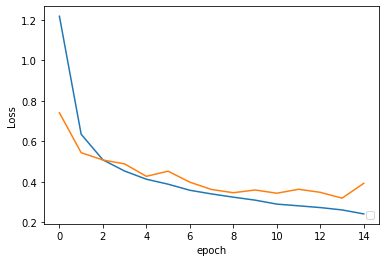

In [43]:
plt.plot(range(len(loss_epoch_train)), loss_epoch_train)
plt.plot(range(len(loss_epoch_test)), loss_epoch_test)
plt.xlabel('epoch')
plt.ylabel('Loss')
l1 = plt.legend([loss_epoch_train, loss_epoch_test], ['Train, Test'], loc = 'lower right')
plt.show()